# Training HOG Features - WITH PCA, NO SMOTE, LINEAR KERNEL ONLY
## Train SVC với HOG features (có dùng PCA, không dùng SMOTE, chỉ dùng linear kernel)

Pipeline:
1. **Load features**: Đọc HOG features từ features_hog/
2. **Scale**: StandardScaler
3. **PCA**: Giảm chiều dữ liệu (n_components=0.95)
4. **GridSearchCV**: Tìm best params cho SVC (chỉ linear kernel, với class_weight='balanced')
5. **Evaluate**: Đánh giá model


In [3]:
# 1. Import thư viện
import os
import json
import numpy as np
import joblib
import time
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# 2. Load HOG features

# Load train features
train_data = np.load('/content/drive/MyDrive/CV1/train_features.npz')
X_train = train_data['X']
y_train = train_data['y']

# Load test features
test_data = np.load('/content/drive/MyDrive/CV1/test_features.npz')
X_test = test_data['X']
y_test = test_data['y']

# Load class mapping
with open('/content/drive/MyDrive/CV1/class_mapping.json', 'r') as f:
    class_mapping = json.load(f)
class_mapping = {int(k): v for k, v in class_mapping.items()}

print(f"Train features: {X_train.shape}")
print(f"Test features: {X_test.shape}")
print(f"Số lớp: {len(class_mapping)}")


Train features: (10968, 8100)
Test features: (2743, 8100)
Số lớp: 23


In [5]:
# 3. Scale features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train scaled: {X_train_scaled.shape}")
print(f"Test scaled: {X_test_scaled.shape}")


Train scaled: (10968, 8100)
Test scaled: (2743, 8100)


In [6]:
# 4. Apply PCA để giảm chiều

# Giữ 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("="*60)
print("KÍCH THƯỚC TẬP TRAIN TRƯỚC VÀ SAU PCA")
print("="*60)
print(f"\nTrước PCA:")
print(f"   • Số samples: {X_train_scaled.shape[0]}")
print(f"   • Số features: {X_train_scaled.shape[1]}")
print(f"   • Kích thước: {X_train_scaled.shape}")
print(f"\nSau PCA:")
print(f"   • Số samples: {X_train_pca.shape[0]}")
print(f"   • Số features: {X_train_pca.shape[1]}")
print(f"   • Kích thước: {X_train_pca.shape}")
print(f"\nThông tin PCA:")
print(f"   • Explained variance: {pca.explained_variance_ratio_.sum():.4f}")
print(f"   • Giảm chiều: {X_train_scaled.shape[1]} → {X_train_pca.shape[1]} ({X_train_pca.shape[1]/X_train_scaled.shape[1]*100:.1f}%)")
print("="*60)


KÍCH THƯỚC TẬP TRAIN TRƯỚC VÀ SAU PCA

Trước PCA:
   • Số samples: 10968
   • Số features: 8100
   • Kích thước: (10968, 8100)

Sau PCA:
   • Số samples: 10968
   • Số features: 1963
   • Kích thước: (10968, 1963)

Thông tin PCA:
   • Explained variance: 0.9501
   • Giảm chiều: 8100 → 1963 (24.2%)


In [15]:
# 5. Train SVC với default params (sau PCA)
print("\nBước 1: Train SVC với default params (sau PCA)...")
print("="*60)

# Train SVC default với class_weight='balanced'
svc_default = SVC(class_weight='balanced', random_state=42)

print("Đang train SVC default...")
start_default = time.time()
svc_default.fit(X_train_pca, y_train)
end_default = time.time()

# Evaluate
y_pred_default = svc_default.predict(X_test_pca)
acc_default = accuracy_score(y_test, y_pred_default)
f1_default = f1_score(y_test, y_pred_default, average='macro')

duration_default = end_default - start_default
print(f"Thời gian train: {duration_default:.2f} giây")
print(f"Test Metrics (SVC default + class_weight='balanced'):")
print(f"   • Accuracy: {acc_default:.4f}")
print(f"   • F1-macro: {f1_default:.4f}")
print("="*60)



Bước 1: Train SVC với default params (sau PCA)...
Đang train SVC default...
Thời gian train: 175.77 giây
Test Metrics (SVC default + class_weight='balanced'):
   • Accuracy: 0.2829
   • F1-macro: 0.2534


In [8]:
# 6. Setup GridSearchCV với SVC (chỉ linear kernel)

# Define parameter grid - chỉ linear kernel, bỏ rbf
# Bỏ gamma vì với linear kernel, gamma không có tác dụng
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear']
}

# Setup GridSearchCV với class_weight='balanced'
svc = SVC(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(
    svc,
    param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

print(f"Parameter grid: {param_grid}")
print(f"Cross-validation: 3-fold")
print(f"Scoring: f1_macro (phù hợp cho imbalanced data)")
print(f"Class weight: balanced")
print(f"Kernel: chỉ linear (không dùng rbf)")
print(f"Lưu ý: Bỏ gamma vì không có tác dụng với linear kernel")


Parameter grid: {'C': [0.1, 1, 10, 100], 'kernel': ['linear']}
Cross-validation: 3-fold
Scoring: f1_macro (phù hợp cho imbalanced data)
Class weight: balanced
Kernel: chỉ linear (không dùng rbf)
Lưu ý: Bỏ gamma vì không có tác dụng với linear kernel


In [9]:
# 7. Train model với GridSearchCV
print(f"Thời gian bắt đầu training: {datetime.now().strftime('%H:%M:%S')}")
print(f"Tổng số combinations: {len(param_grid['C']) * len(param_grid['kernel'])}")
print(f"Số folds: 3")
print(f"Training với {X_train_pca.shape[0]} samples, {X_train_pca.shape[1]} features (sau PCA, không dùng SMOTE)")
print("\n" + "="*60)
print("BẮT ĐẦU GRIDSEARCH...")
print("="*60 + "\n")

start_time = time.time()
grid_search.fit(X_train_pca, y_train)
end_time = time.time()

training_duration = end_time - start_time
minutes = int(training_duration // 60)
seconds = int(training_duration % 60)

print("\n" + "="*60)
print("TRAINING HOÀN THÀNH!")
print("="*60)
print(f"\nThời gian training: {minutes} phút {seconds} giây")
print(f"Thời gian kết thúc: {datetime.now().strftime('%H:%M:%S')}")

print(f"\nBest parameters:")
for param, value in grid_search.best_params_.items():
    print(f"   • {param}: {value}")
print(f"\nBest cross-validation F1-macro score: {grid_search.best_score_:.4f}")

# Hiển thị top 5 best models
print(f"\nTop 5 best models (theo F1-macro):")
results = grid_search.cv_results_
indices = np.argsort(results['mean_test_score'])[::-1][:5]
for i, idx in enumerate(indices, 1):
    print(f"   {i}. F1-macro: {results['mean_test_score'][idx]:.4f} - Params: {results['params'][idx]}")


Thời gian bắt đầu training: 12:41:32
Tổng số combinations: 4
Số folds: 3
Training với 10968 samples, 1963 features (sau PCA, không dùng SMOTE)

BẮT ĐẦU GRIDSEARCH...

Fitting 3 folds for each of 4 candidates, totalling 12 fits

TRAINING HOÀN THÀNH!

Thời gian training: 24 phút 22 giây
Thời gian kết thúc: 13:05:55

Best parameters:
   • C: 0.1
   • kernel: linear

Best cross-validation F1-macro score: 0.2048

Top 5 best models (theo F1-macro):
   1. F1-macro: 0.2048 - Params: {'C': 100, 'kernel': 'linear'}
   2. F1-macro: 0.2048 - Params: {'C': 10, 'kernel': 'linear'}
   3. F1-macro: 0.2048 - Params: {'C': 1, 'kernel': 'linear'}
   4. F1-macro: 0.2048 - Params: {'C': 0.1, 'kernel': 'linear'}


In [10]:
# 8. Evaluate trên test set

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pca)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"\nTest Metrics:")
print(f"   • Accuracy: {test_accuracy:.4f}")
print(f"   • F1-macro: {test_f1_macro:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[class_mapping[i] for i in sorted(class_mapping.keys())]))



Test Metrics:
   • Accuracy: 0.2176
   • F1-macro: 0.1989

Classification Report:
                 precision    recall  f1-score   support

          Clams       0.08      0.11      0.09        99
         Corals       0.14      0.17      0.15       100
          Crabs       0.22      0.26      0.24       100
        Dolphin       0.30      0.39      0.34       157
            Eel       0.07      0.09      0.08        99
           Fish       0.12      0.10      0.11        99
     Jelly Fish       0.33      0.40      0.36       169
        Lobster       0.12      0.13      0.13       100
    Nudibranchs       0.07      0.06      0.06       100
        Octopus       0.11      0.12      0.12       112
          Otter       0.55      0.63      0.59       100
        Penguin       0.20      0.17      0.18        96
        Puffers       0.14      0.11      0.12       106
       Sea Rays       0.15      0.12      0.13       103
    Sea Urchins       0.40      0.45      0.42       116
    

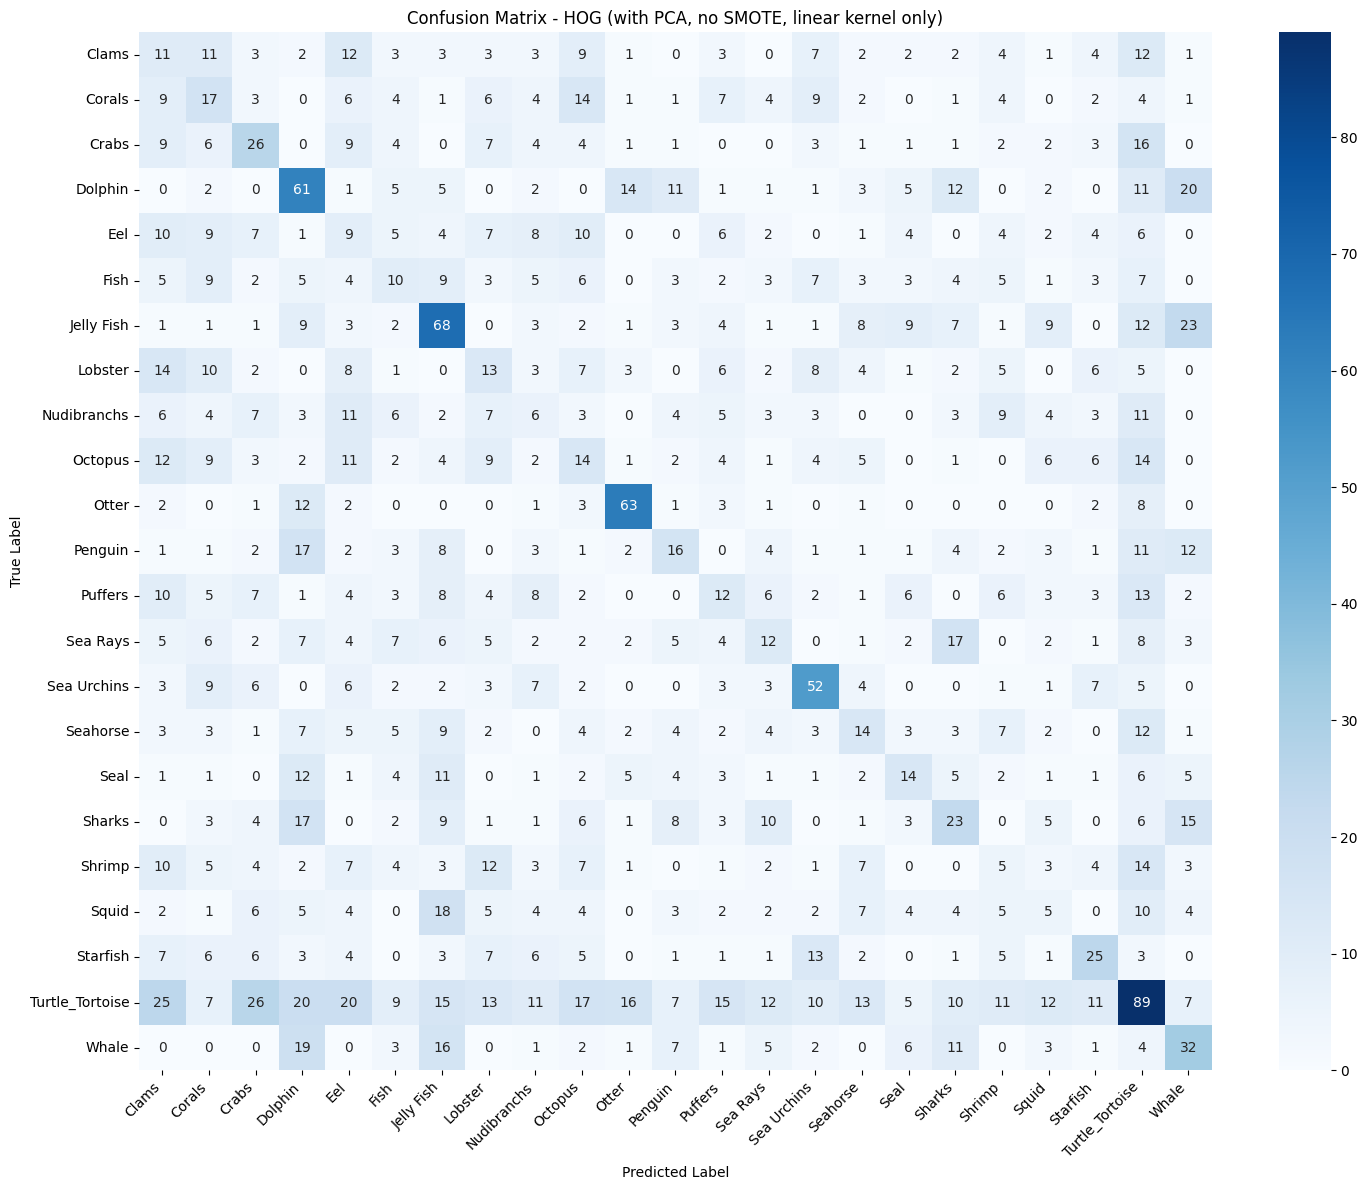

Đã lưu confusion_matrix_hog_pca_no_smote_linear.png


In [11]:
# 9. Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_mapping[i] for i in sorted(class_mapping.keys())],
            yticklabels=[class_mapping[i] for i in sorted(class_mapping.keys())])
plt.title('Confusion Matrix - HOG (with PCA, no SMOTE, linear kernel only)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_hog_pca_no_smote_linear.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu confusion_matrix_hog_pca_no_smote_linear.png")


In [16]:
# 10. So sánh results và phân tích overfitting
print("\nSo sánh kết quả:")
print("="*60)
print(f"SVC Default (class_weight='balanced'):")
print(f"   • Accuracy: {acc_default:.4f}")
print(f"   • F1-macro: {f1_default:.4f}")
print(f"SVC sau GridSearchCV (tối ưu theo F1-macro):")
print(f"   • Accuracy: {test_accuracy:.4f}")
print(f"   • F1-macro: {test_f1_macro:.4f}")
print(f"\nImprovement:")
print(f"   • Accuracy: {(test_accuracy - acc_default)*100:+.2f}%")
print(f"   • F1-macro: {(test_f1_macro - f1_default)*100:+.2f}%")
print("="*60)

# Phân tích Overfitting/Underfitting (dùng F1-macro vì đó là metric chính)
print("\nPhân tích Overfitting (theo F1-macro):")
print("="*60)
print(f"Best CV F1-macro (train):  {grid_search.best_score_:.4f}")
print(f"Test F1-macro:              {test_f1_macro:.4f}")
print(f"Gap (CV - Test):            {(grid_search.best_score_ - test_f1_macro):.4f}")

gap = grid_search.best_score_ - test_f1_macro
if gap > 0.05:
    print("\n OVERFITTING: CV F1-macro cao hơn Test nhiều (>0.05)")
    print("   → Model học tốt trên train nhưng kém trên test")
    print("   → Cân nhắc: giảm C, tăng regularization")
elif gap < -0.05:
    print("\n UNDERFITTING: Test cao hơn CV (hiếm gặp)")
    print("   → Model có thể cần phức tạp hơn")
else:
    print("\n GOOD FIT: CV F1-macro và Test F1-macro tương đương")
    print("   → Model generalize tốt!")
print("="*60)



So sánh kết quả:
SVC Default (class_weight='balanced'):
   • Accuracy: 0.2829
   • F1-macro: 0.2534
SVC sau GridSearchCV (tối ưu theo F1-macro):
   • Accuracy: 0.2176
   • F1-macro: 0.1989

Improvement:
   • Accuracy: -6.53%
   • F1-macro: -5.45%

Phân tích Overfitting (theo F1-macro):
Best CV F1-macro (train):  0.2048
Test F1-macro:              0.1989
Gap (CV - Test):            0.0060

 GOOD FIT: CV F1-macro và Test F1-macro tương đương
   → Model generalize tốt!


In [17]:
# 10. Lưu model và scaler
print("\n Đang lưu model...")

output_dir = 'models_hog_no_pca_no_smote_linear'
os.makedirs(output_dir, exist_ok=True)

# Lưu model
joblib.dump(best_model, f'{output_dir}/svc_model.pkl')
joblib.dump(scaler, f'{output_dir}/scaler.pkl')
joblib.dump(grid_search, f'{output_dir}/grid_search.pkl')

# Lưu class mapping
with open(f'{output_dir}/class_mapping.json', 'w') as f:
    json.dump(class_mapping, f, indent=2, ensure_ascii=False)

# Lưu results
gap_f1 = grid_search.best_score_ - test_f1_macro
results = {
    'method': 'HOG (with PCA, no SMOTE, linear kernel only)',
    'scoring_metric': 'f1_macro',
    'svc_default_accuracy': float(acc_default),
    'svc_default_f1_macro': float(f1_default),
    'best_params': grid_search.best_params_,
    'best_cv_f1_macro': float(grid_search.best_score_),
    'test_accuracy_after_tuning': float(test_accuracy),
    'test_f1_macro_after_tuning': float(test_f1_macro),
    'improvement_accuracy': float(test_accuracy - acc_default),
    'improvement_f1_macro': float(test_f1_macro - f1_default),
    'cv_test_f1_gap': float(gap_f1),
    'overfitting_status': 'OVERFITTING' if gap_f1 > 0.05 else ('UNDERFITTING' if gap_f1 < -0.05 else 'GOOD FIT'),
    'original_dimension': X_train.shape[1],
    'pca_components': X_train_pca.shape[1],
    'pca_variance_ratio': float(pca.explained_variance_ratio_.sum()),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'num_classes': len(class_mapping),
    'used_pca': True,
    'used_smote': False,
    'kernel': 'linear_only'
}

with open(f'{output_dir}/results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Đã lưu model vào thư mục: {output_dir}")
print(f"✓ Files: svc_model.pkl, scaler.pkl, grid_search.pkl, results.json")



 Đang lưu model...
✓ Đã lưu model vào thư mục: models_hog_no_pca_no_smote_linear
✓ Files: svc_model.pkl, scaler.pkl, grid_search.pkl, results.json


In [18]:
# 12. Tổng kết
print(f"\n{'='*60}")
print(f" TRAINING HOÀN THÀNH - HOG (WITH PCA, NO SMOTE, LINEAR KERNEL ONLY)")
print(f"{'='*60}")
print(f"\n Results Summary:")
print(f"   • Original dimension: {X_train.shape[1]}")
print(f"   • After PCA: {X_train_pca.shape[1]} components")
print(f"   • Variance retained: {pca.explained_variance_ratio_.sum():.4f}")
print(f"   • Train samples: {X_train_pca.shape[0]} (không dùng SMOTE)")
print(f"   • Kernel: chỉ linear (không dùng rbf)")
print(f"   • Scoring metric: F1-macro (phù hợp cho imbalanced data)")
print(f"   • SVC Default Accuracy: {acc_default:.4f}")
print(f"   • SVC Default F1-macro: {f1_default:.4f}")
print(f"   • Best CV F1-macro: {grid_search.best_score_:.4f}")
print(f"   • Test Accuracy (sau tuning): {test_accuracy:.4f}")
print(f"   • Test F1-macro (sau tuning): {test_f1_macro:.4f}")
print(f"   • Improvement (Accuracy): {(test_accuracy - acc_default)*100:+.2f}%")
print(f"   • Improvement (F1-macro): {(test_f1_macro - f1_default)*100:+.2f}%")
print(f"   • CV-Test F1 Gap: {(grid_search.best_score_ - test_f1_macro):.4f}")
print(f"   • Best params: {grid_search.best_params_}")
print(f"\n Output:")
print(f"   • Model: {output_dir}/")
print(f"   • Confusion matrix: confusion_matrix_hog_pca_no_smote_linear.png")
print(f"\n{'='*60}")



 TRAINING HOÀN THÀNH - HOG (WITH PCA, NO SMOTE, LINEAR KERNEL ONLY)

 Results Summary:
   • Original dimension: 8100
   • After PCA: 1963 components
   • Variance retained: 0.9501
   • Train samples: 10968 (không dùng SMOTE)
   • Kernel: chỉ linear (không dùng rbf)
   • Scoring metric: F1-macro (phù hợp cho imbalanced data)
   • SVC Default Accuracy: 0.2829
   • SVC Default F1-macro: 0.2534
   • Best CV F1-macro: 0.2048
   • Test Accuracy (sau tuning): 0.2176
   • Test F1-macro (sau tuning): 0.1989
   • Improvement (Accuracy): -6.53%
   • Improvement (F1-macro): -5.45%
   • CV-Test F1 Gap: 0.0060
   • Best params: {'C': 0.1, 'kernel': 'linear'}

 Output:
   • Model: models_hog_no_pca_no_smote_linear/
   • Confusion matrix: confusion_matrix_hog_pca_no_smote_linear.png

